# 1. Introduction

**In this project, we aim to predict customer churn based on a variety of features from a telecom dataset.  
Churn prediction is crucial for businesses to retain their customers and improve long-term profitability.  
We will perform data preprocessing, feature engineering, model training, hyperparameter tuning, and evaluation  
using various machine learning models. Our primary evaluation metric is the ROC AUC score due to the binary  
and potentially imbalanced nature of the target variable.**
**Fun Fact (or maybe not?)**  
Churn isn’t just a telecom problem — it’s a lifestyle. Customers wake up, sip their overpriced coffee, and suddenly decide to ghost your service like a bad Tinder match. It’s not you, it’s them... or maybe it **is** you — your billing system, your customer support hold music, or that mysterious “activation fee.”  
**Our job as churn detectives is to read the tea leaves (or spreadsheets) and predict when someone is about to jump off the ship**

# 2.Loading libraries and importing data

In [1]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=05ba91323aa24ea7077d853283deeb9cc44daaebceed94aa1843421183835115
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency
import plotly.express as px
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [4]:
dtypes = {
    'TotalCharges': 'float64',  
    'SeniorCitizen': 'category',  
    'Partner': 'category',
    'PaymentMethod': 'category'
}
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv', dtype=dtypes, na_values=[' ', 'NA', 'N/A'])

# 3.Data Manipulation

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   object  
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   object  
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   object  
 7   MultipleLines     7043 non-null   object  
 8   InternetService   7043 non-null   object  
 9   OnlineSecurity    7043 non-null   object  
 10  OnlineBackup      7043 non-null   object  
 11  DeviceProtection  7043 non-null   object  
 12  TechSupport       7043 non-null   object  
 13  StreamingTV       7043 non-null   object  
 14  StreamingMovies   7043 non-null   object  
 15  Contract          7043 non-null   object  
 16  PaperlessBilling  7043 n

In [7]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner             category
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn                 object
dtype: object

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**The dataset explains us the followings:**
* **Tenure** -Total subscription duration
* **Total Charges**-Total bill amount
* **Churn** -Customers who cancelled their subscription ,unfortunately.
* **Demographic information**-Gender,age,dependents.

In [9]:
print( "Missing Values:\n", df.isna().sum())

Missing Values:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


# 3.1 Dealing with missing values


The missing 11 values are from total charges column.We can either fill it with mode/median(common approach) or look for its relation with other columns.
**(Total charges = Monthly charges * Tenure)**
* -->There are few rows where tenure is '0'.This will lead unexpected total charges.
* -->Since these rows equal nearly 0 compared to total rows , we can drop those rows.


In [10]:
print(df.loc[df['tenure'] == 0])
df['TotalCharges'] = df['tenure'] * df['MonthlyCharges']
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
print( "Missing Values:\n", df.isna().sum())

      customerID  gender SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female             0     Yes        Yes       0   
753   3115-CZMZD    Male             0      No        Yes       0   
936   5709-LVOEQ  Female             0     Yes        Yes       0   
1082  4367-NUYAO    Male             0     Yes        Yes       0   
1340  1371-DWPAZ  Female             0     Yes        Yes       0   
3331  7644-OMVMY    Male             0     Yes        Yes       0   
3826  3213-VVOLG    Male             0     Yes        Yes       0   
4380  2520-SGTTA  Female             0     Yes        Yes       0   
5218  2923-ARZLG    Male             0     Yes        Yes       0   
6670  4075-WKNIU  Female             0     Yes        Yes       0   
6754  2775-SEFEE    Male             0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753      

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


* **We have succesfully filled out Null/NaN values**

In [11]:
columns_to_drop = ['customerID', 'gender', 'PhoneService', 'MultipleLines']
clean_df = df.drop(columns=columns_to_drop)
clean_df['Churn_numeric'] = clean_df['Churn'].map({'Yes': 1, 'No': 0})
print(clean_df.head())
print(clean_df.isna().sum())

  SeniorCitizen Partner Dependents  tenure InternetService OnlineSecurity  \
0             0     Yes         No       1             DSL             No   
1             0      No         No      34             DSL            Yes   
2             0      No         No       2             DSL            Yes   
3             0      No         No      45             DSL            Yes   
4             0      No         No       2     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

         Contract PaperlessBilling              PaymentMethod  MonthlyCharges  \
0  Mo

# 4. Data Visualization

In [12]:
fig = px.scatter_3d(clean_df, x='tenure', y='MonthlyCharges', z='TotalCharges',
                    color='Churn', opacity=0.7, 
                    title='<b>Churn Hotspots Revealed</b><br><sup>High Monthly Charges + Short Tenure = Danger Zone</sup>',
                    labels={'tenure': 'Tenure (Months)', 'MonthlyCharges': 'Monthly ($)', 'TotalCharges': 'Total ($)'},
                    color_discrete_map={'No': '#1f77b4', 'Yes': '#ff7f0e'})

fig.update_layout(
    scene=dict(
        xaxis_title='<b>Tenure (Risk Factor)</b>',
        yaxis_title='<b>Monthly Charges ($)</b>',
        zaxis_title='<b>Total Spend</b>'),
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title_text='<b>Churn Status</b>'
)
fig.show()

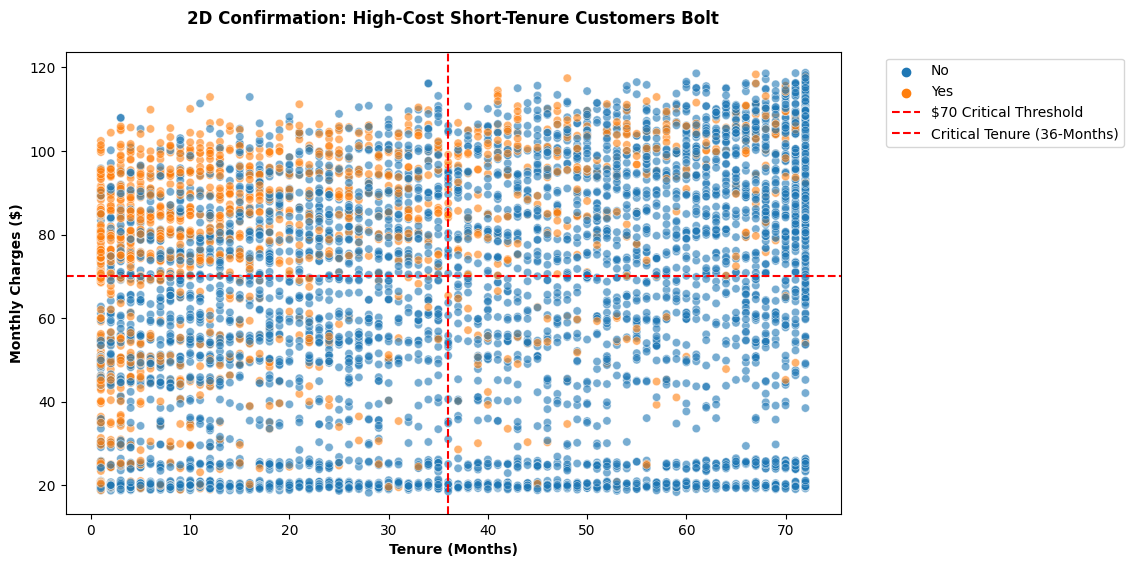

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', 
                 alpha=0.6)
plt.axhline(y=70, color='red', linestyle='--', label='$70 Critical Threshold')
plt.axvline(x=36, color='red', linestyle='--', label='Critical Tenure (36-Months)')
plt.title("2D Confirmation: High-Cost Short-Tenure Customers Bolt", fontweight='bold', pad=20)
plt.xlabel("Tenure (Months)", fontweight='bold')
plt.ylabel("Monthly Charges ($)", fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

* We see that the customers who churn are clustered on the top left corner
* **(Tenure is less than 36-months && Monthly charge is more than 70$)**

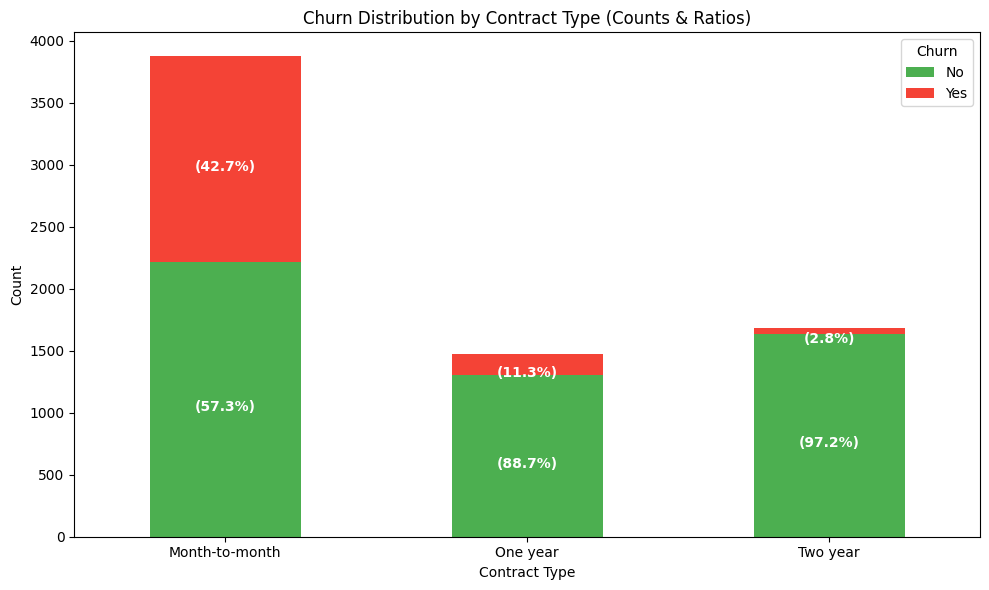

In [14]:
cross_tab = pd.crosstab(clean_df['Contract'], clean_df['Churn'])
percentage_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100  # Convert to percentages

# 2. Plot stacked bars
ax = cross_tab.plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336'], figsize=(10, 6))
plt.title('Churn Distribution by Contract Type (Counts & Ratios)')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 3. Annotate ratios on each bar segment
for i, contract in enumerate(cross_tab.index):
    total = cross_tab.loc[contract].sum()
    for j, churn_status in enumerate(cross_tab.columns):
        count = cross_tab.loc[contract, churn_status]
        percentage = percentage_tab.loc[contract, churn_status]
        # Position annotations at the middle of each bar segment
        x = i
        y = cross_tab.loc[contract, :churn_status].sum() - count/2
        ax.text(x, y, f'\n({percentage:.1f}%)', 
                ha='center', va='center', color='white', fontweight='bold')

plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


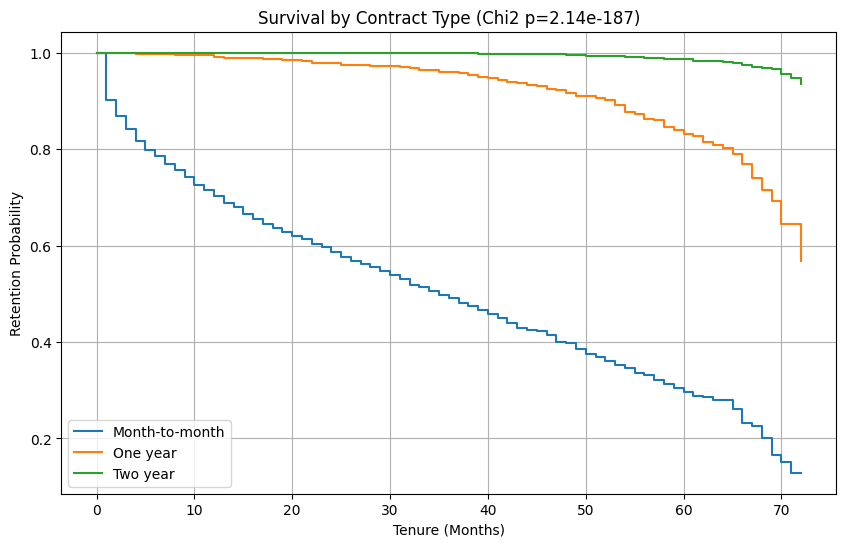

In [15]:
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for contract in clean_df['Contract'].unique():
    mask = clean_df['Contract'] == contract
    kmf.fit(clean_df[mask]['tenure'], clean_df[mask]['Churn_numeric'], label=contract)
    kmf.plot_survival_function(ci_show=False)

plt.title('Survival by Contract Type (Chi2 p=2.14e-187)')
plt.xlabel('Tenure (Months)')
plt.ylabel('Retention Probability')
plt.grid()
plt.show()

* **Contract type has huge impact on churn ratio**
* **Nearly half of all month-to-month customers churn**
  

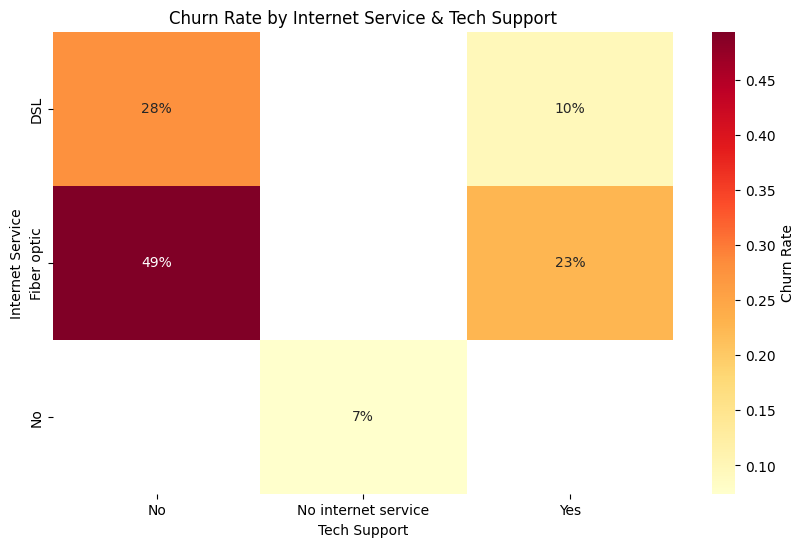

In [16]:
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Group by two categorical columns and calculate mean churn rate
heatmap_data = df.groupby(['InternetService', 'TechSupport'])['Churn_numeric'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap='YlOrRd', cbar_kws={'label': 'Churn Rate'})
plt.title('Churn Rate by Internet Service & Tech Support')
plt.xlabel('Tech Support')
plt.ylabel('Internet Service')
plt.show()

* **Customers who do not receive tech support and has fiber optic service tend to churn more.**

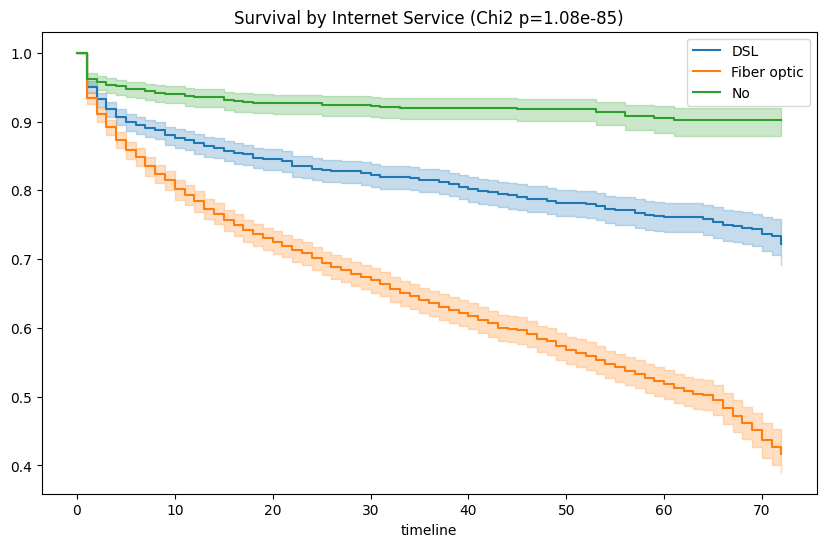

In [17]:
plt.figure(figsize=(10, 6))
for service in clean_df['InternetService'].unique():
    mask = clean_df['InternetService'] == service
    kmf.fit(clean_df[mask]['tenure'], clean_df[mask]['Churn_numeric'], label=service)
    kmf.plot_survival_function()

plt.title('Survival by Internet Service (Chi2 p=1.08e-85)')
plt.show()

* **Customers who have fiber optic access have higher probability to churn.**

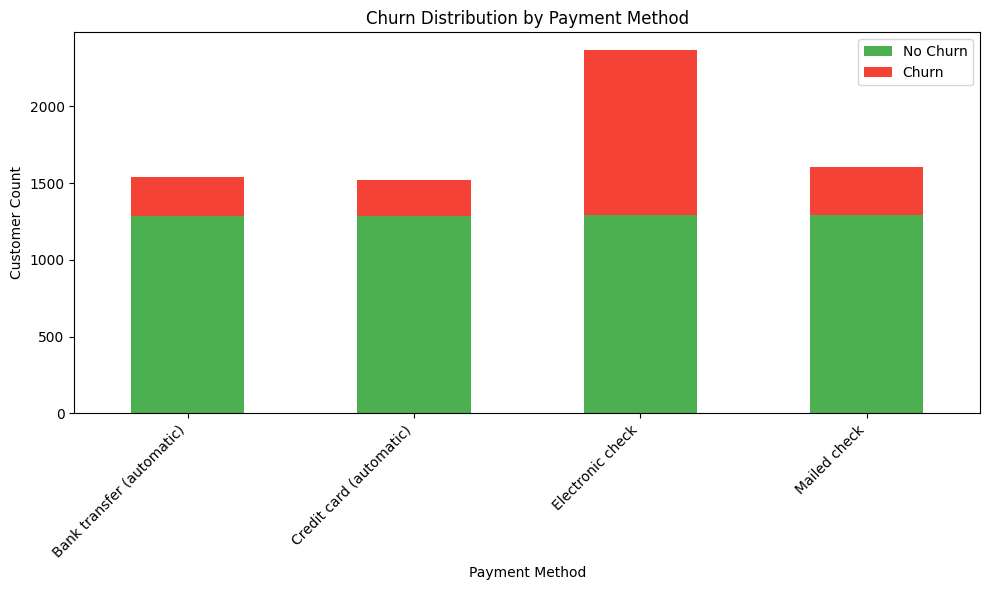

In [18]:
cross_tab = pd.crosstab(clean_df['PaymentMethod'], clean_df['Churn_numeric'])
percentages = cross_tab.div(cross_tab.sum(axis=1), axis=0)

ax = cross_tab.plot(kind='bar', stacked=True, figsize=(10,6), color=['#4CAF50', '#F44336'])
plt.title("Churn Distribution by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Customer Count")
plt.legend(["No Churn", "Churn"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* **Customers who pays via electronic check are more likey to churn.**

# 5.Data Preprocessing

In [19]:

X = df.drop(['Churn_numeric', 'Churn'], axis=1) 
y = df['Churn_numeric']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Create model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

* **Ready for our first model.**

# 6.Machine Learning and Modelling

In [20]:

# Train and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



In [21]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True) ,
    'KNN': KNeighborsClassifier() 
}

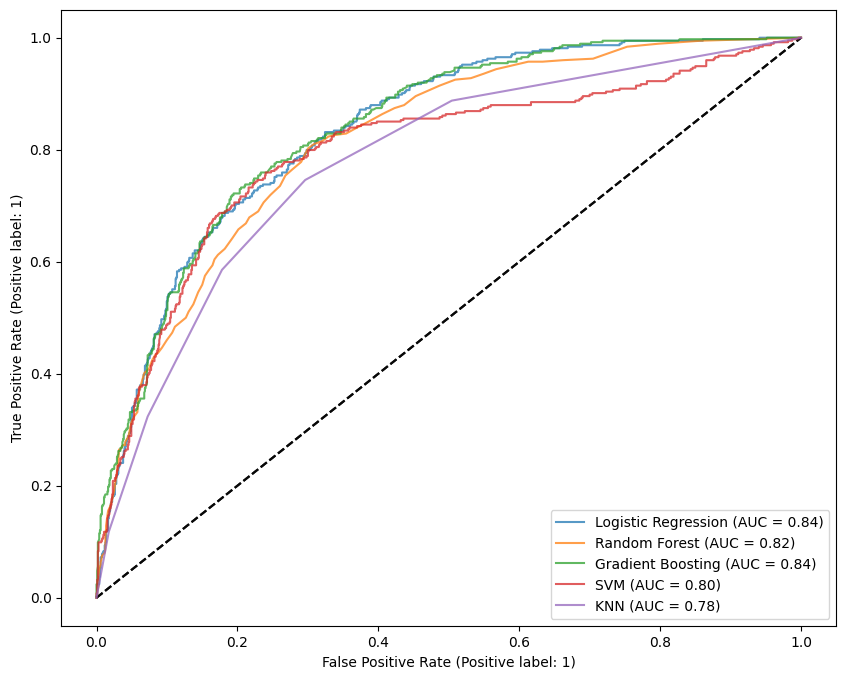

In [22]:
plt.figure(figsize=(10, 8))
for name, clf in models.items():
    # Create pipeline for each model
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    
    # ROC Curve
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    RocCurveDisplay.from_estimator(
        pipe, X_test, y_test, name=name, ax=plt.gca(), alpha=0.75
    )



Logistic Regression - Confusion Matrix


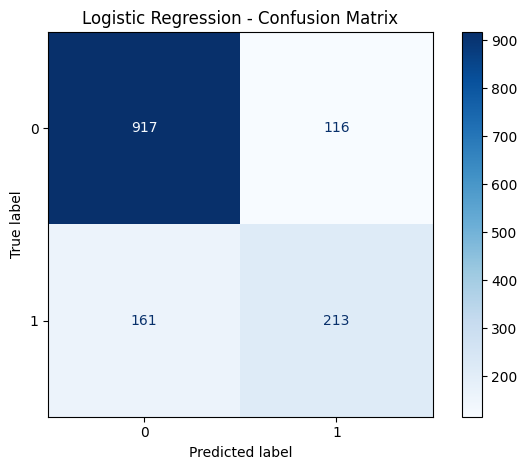


Random Forest - Confusion Matrix


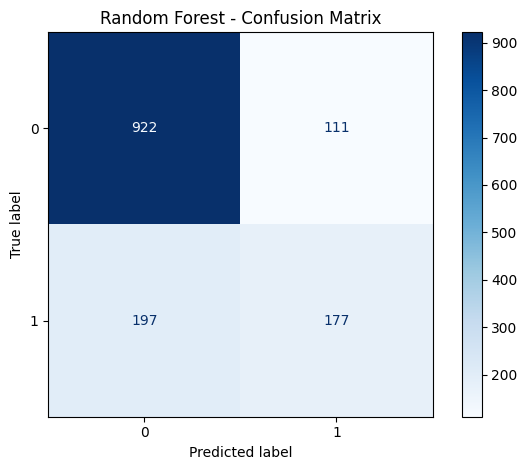


Gradient Boosting - Confusion Matrix


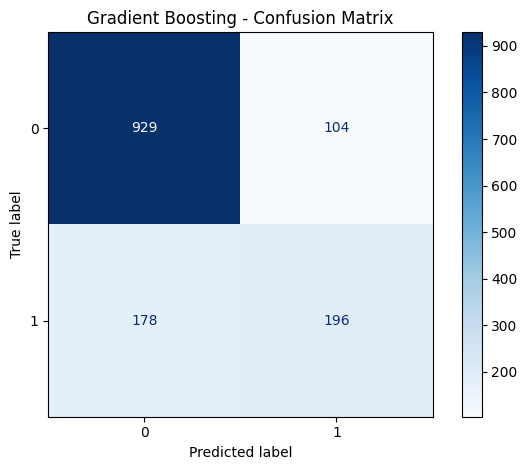


SVM - Confusion Matrix


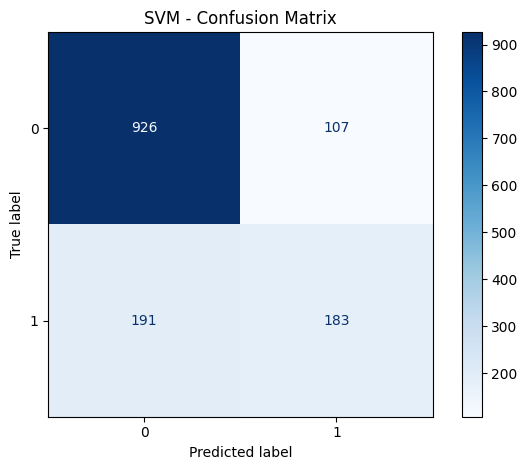


KNN - Confusion Matrix


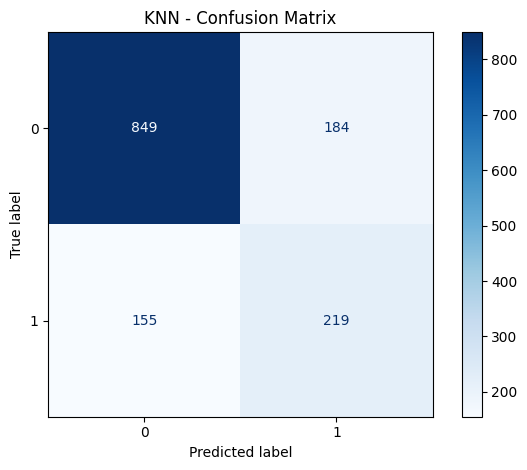

In [23]:
for name, clf in models.items():
    print(f"\n{name} - Confusion Matrix")
    
    # Recreate and fit pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    
    # Compute and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot
    disp.plot(cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

* **After inspection scores and confusion matrices we came to conclusion that gradient boosting is the best model.**
* **Now we shall find the best parameters.**

In [24]:

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.8, 1.0],
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

grid = GridSearchCV(
    gb_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid.fit(X_train, y_train)

# Best model & score
print("Best Parameters:", grid.best_params_)
print("Best AUC Score:", grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best AUC Score: 0.8489954408156324



**Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}Best AUC Score: 0.8489954408156324**


# 8.Recomendations

**The company should focus on customers with higher predicted churn probabilities by offering incentives or improving service quality.**
## Recommendations

- **Customers who pay via electronic check**:  
  These customers consistently exhibit higher churn rates. This might stem from perceptions of insecurity or lack of convenience. One strategic option is to **partner with trusted digital payment platforms** or **introduce crypto-based payment options** to appeal to tech-savvy users and improve retention.

- **Customers who recently joined and have higher-than-average bills**:  
  New customers experiencing bill shock are more likely to leave. To mitigate this, the company could **offer a discounted rate in exchange for a longer-term contract**, or a gradual billing structure that eases them into full payments after a trial or onboarding period.

- **Customers with no long-term contract, paying month-to-month**:  
  These subscribers are the **most at risk of churning**, as they have low commitment and high flexibility. The company should **prioritize engagement campaigns** targeting this group — e.g., loyalty bonuses, early renewal discounts, or personalized offers — to encourage them to opt into longer-term plans and reduce churn risk.
